# Cataract Classification Practice
Instituto Tecnológico de Monterrey
Andrés Magaña Pérez
A01067963

Para esta primera parte, importamos el drive que tiene las imágenes con las que vamos a trabajar.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

# Path en Drive de la carpeta del dataset
dataset_path = "/content/drive/My Drive/AI_Aplicaciones_Avanzadas/cataract_classification/cataract_classification_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!ls '/content/drive/My Drive/AI_Aplicaciones_Avanzadas/cataract_classification/cataract_classification_data'

immature  mature


En el siguiente paso vamos a importar las librerías que necesitamos para hacer la práctica.

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

# Configuramos los parámetros de ImageDataGenerator
- rescale - redimensiona las imágenes en una escala de 0 a 255.
- rotation_range - el rango de rotación que puede aplicar.
- width_shift_range - cambios horizontales aleatorios.
- height_shift_range - cambios verticales aleatorios.
- shear_range - crea un estilo de distorsión aleatoria.
- zoom_range - zooms aleatorios en las imágenes.
- horizontal_flip - cambia la imagen horizontalmente con un 50% de probabilidad.
- validation_split - especifica el porcentaje de datos que se dejará para validación.


In [42]:
# Creamos una instancia de ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1/255,   # Scale the image between 0 and 1
    rotation_range=95,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # De esta forma guardamos el 20% para pruebas
)

Hacemos un llamado a la instancia anteriormente realizada con el dataset de nuestras imágenes:

In [52]:
# Cargamos las imágenes del directorio drive a la instancia del ImageDataGenerator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(416, 416),  # Escala las imágenes a su tamaño 416x416
    batch_size=32, # Aquí configuramos el tamaño del batch que vamos a manejar
    class_mode='binary',  # Puede ser binario o categórico dependiendo del problema
    subset="training", # especificamos que este va a ser nuestro grupo de entrenamiento
    shuffle=True,
    seed=42 # Se utiliza para que el shuffle en training y testing sea de la misma forma
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(416, 416),
    batch_size=32,
    class_mode='binary',
    subset="validation", # especificamos que este va a ser nuestro grupo de validación
    shuffle=True,
    seed=42
)

Found 409 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


In [53]:
# Procesamos las imágenes por partes, no todas al mismo tiempo. Manejamos un batch de 32 imágenes.
# Con next obtenemos la imagen de cada valor, con su label correspondiente
images, labels = next(train_generator)

# Seleccionamos 3 imágenes para mostrar con sus labels correspondientes
test_images = images[:3]
test_labels = labels[:3]

print(len(images))
print(len(labels))

32
32


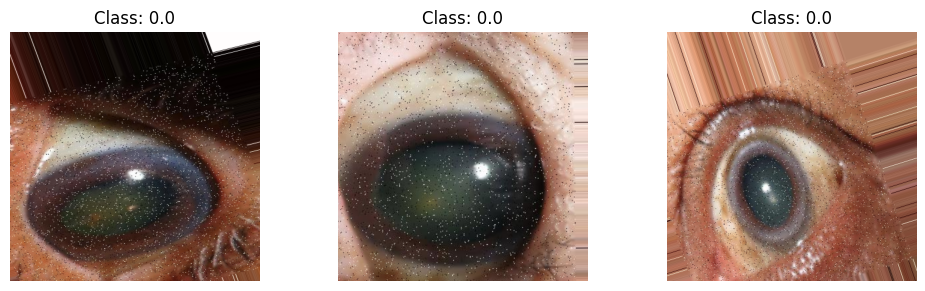

In [49]:
# Utilizamos matplotlib para mostrar las imágenes
plt.figure(figsize=(10, 3))

for i, (img, label) in enumerate(zip(test_images, test_labels), start=1):
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()